In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tensornetworks_pytorch.TNModels import PosMPS, Born
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

print(torch.__version__)

1.8.0.dev20201128


In [2]:
### import data
import pickle
for dataset in ['biofam',
    'flare','lymphography','spect','tumor','votes']:
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1' # biofam seemed to have an encoding issue which this fixes
        a = u.load()
    X=a[0].astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")

def load_dataset(dataset):
    with open('datasets/'+dataset, 'rb') as f:
        u = pickle._Unpickler(f)
        u.encoding = 'latin1'
        a = u.load()
    X=a[0]
    X=X.astype(int)
    print(f"╭──{dataset}")
    print(f"│ data shape:{X.shape}")
    print(f"│ range of X values: {X.min()} -- {X.max()}")
    print(f"╰───────────────────")
    d = X.max()+1
    return X, d

╭──biofam
│ data shape:(2000, 16)
│ range of X values: 0 -- 7
╰───────────────────
╭──flare
│ data shape:(1065, 13)
│ range of X values: 0 -- 7
╰───────────────────
╭──lymphography
│ data shape:(148, 19)
│ range of X values: 0 -- 7
╰───────────────────
╭──spect
│ data shape:(187, 23)
│ range of X values: 0 -- 1
╰───────────────────
╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
╭──votes
│ data shape:(435, 17)
│ range of X values: 0 -- 2
╰───────────────────


In [4]:
# torch.autograd.set_detect_anomaly(True)
def train(self, dataset, batchsize, max_epochs, plot=True, **optim_kwargs):
    trainloader = DataLoader(dataset, batch_size=batchsize, shuffle=True)
    optimizer = torch.optim.Adadelta(self.parameters(), **optim_kwargs)
    early_stopping_threshold = 1e-6 # min difference in epoch loss 
    loss_values = [] # store by-epoch avg loss values
    print(f'╭───────────────────────────\n│Training {self.name},')
    print(f'│         batchsize:{batchsize}, {optimizer.__module__}, {optim_kwargs}.')
    av_batch_loss_running = -1e4
    with tqdm(range(max_epochs), unit="epoch", leave=True) as tepochs:
        for epoch in tepochs:
            batch_loss_list = []
            with tqdm(trainloader, unit="batch", leave=False, desc=f"epoch {epoch}") as tepoch:
                for batch in tepoch:
                    for pindex, p in enumerate(self.parameters()):
                        if torch.isnan(p).any():
                            pnames = list(self.state_dict().keys())
                            print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
                            print(f"└────Stopped before epoch {epoch}. NaN in weights {pnames[pindex]}!")
                            if plot:
                                plt.plot(loss_values)
                                plt.show()
                            return loss_values
                    self.zero_grad()
                    neglogprob = 0
                    for x in batch:
                        out = self(x)
                        neglogprob -= out
                    loss = neglogprob / len(batch)
                    loss.backward()
                    # for pindex, p in enumerate(self.parameters()):
                    #     if torch.isnan(p.grad).any():
                    #         pnames = list(self.state_dict().keys())
                    #         print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
                    #         print(f"└────Stopped. NaN value in gradient for {pnames[pindex]}!")
                    #         if plot:
                    #             plt.plot(loss_values)
                    #             plt.show()
                    #         return loss_values
                    optimizer.step()
                    tepoch.set_postfix(loss=loss.item())
                    batch_loss_list.append(loss.item())
                av_batch_loss = torch.Tensor(batch_loss_list).mean().item()
                loss_values.append(av_batch_loss)
                tepochs.set_postfix(av_batch_loss=av_batch_loss)
                if abs(av_batch_loss_running - av_batch_loss) < early_stopping_threshold:
                    print(f"├────Early stopping after epoch {epoch}/{max_epochs}.")
                    break
                av_batch_loss_running = av_batch_loss
    print("│ loss values:", *(f"{x:.3f}" for x in loss_values))
    if plot:
        plt.plot(loss_values)
        plt.show()
    print('│ Finished training.\n╰───────────────────────────\n')
    return loss_values

def train_models(models, batchsize, max_epochs, **optim_kwargs):
    print(f"dataset: {dataset}")
    models_loss_values={}
    for model in models:
        loss_values = train(model, X, batchsize=batchsize, plot=False, max_epochs = max_epochs, **optim_kwargs)
        plt.plot(loss_values, label=model.name)
        plt.ylabel('avg loss (NLL)')
        plt.xlabel('Epoch')
        plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optim_kwargs}")
        models_loss_values[f"{model.name}"]=loss_values
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    plt.show()
    return models_loss_values

In [5]:
### initialize models
dataset = 'tumor'
X,d = load_dataset(dataset)
D = 8

mps      = PosMPS(X, d, D, homogeneous=False)
mps_hom  = PosMPS(X, d, D, homogeneous=True)
# mps_s    = PosMPS(X, d, D, homogeneous=False, log_stability=True)
# mps_s_hom= PosMPS(X, d, D, homogeneous=True, log_stability=True)
rBorn      = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=False) 
rBorn_hom  = Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=False) 
rBorn_s    = Born(X, d, D, dtype=torch.float, homogeneous=False, log_stability=True) 
rBorn_s_hom= Born(X, d, D, dtype=torch.float, homogeneous=True, log_stability=True) 
cBorn      = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=False)
cBorn_hom  = Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=False)
cBorn_s    = Born(X, d, D, dtype=torch.cfloat, homogeneous=False, log_stability=True)
cBorn_s_hom= Born(X, d, D, dtype=torch.cfloat, homogeneous=True, log_stability=True)
models     = (rBorn, cBorn, rBorn_s, cBorn_s, mps)#, mps_c
models_hom = (rBorn_hom, cBorn_hom, rBorn_s_hom, cBorn_s_hom, mps_hom)#, mps_c_hom

def clip_grad(grad, clip_val, param_name, verbose=False):
    """Clip the gradients, to be used as a hook during training."""
    if torch.isnan(grad).any():
        print(f"├─NaN value in gradient of {param_name}, {grad.size()}")
    if grad.dtype==torch.cfloat:
        for ext, v in [("min", grad.real.min()),("max", grad.real.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} real {ext} {v:.2} to size {clip_val})")
        for ext, v in [("min", grad.imag.min()),("max", grad.imag.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} imag {ext} {1.j*v:.2} to size {clip_val})")
        clipped_grad = torch.complex(grad.real.clamp(-clip_val, clip_val),
                                     grad.imag.clamp(-clip_val, clip_val))
    else:
        for ext, v in [("min", grad.min()),("max", grad.max())]:
            if verbose and abs(v) > clip_val:
                print(f"│(clipping {param_name} {ext} {v:.2} to size {clip_val})")
        clipped_grad = torch.clamp(grad, -clip_val, clip_val)
    return clipped_grad

print(f"Models: D={D}, d={d}")
for model in (*models, *models_hom):
    print(f"\t{model.core.shape} model type: {model.name}")
    for param_index, p in enumerate(model.parameters()):
        pnames = list(model.state_dict().keys())
        p.register_hook(lambda grad: clip_grad(grad, 1000, pnames[param_index], verbose=True))
        if torch.isnan(p).any():
            print(f"{pnames[param_index]} contains a NaN value!")

╭──tumor
│ data shape:(339, 17)
│ range of X values: 0 -- 3
╰───────────────────
Models: D=8, d=4
	torch.Size([17, 4, 8, 8]) model type: Born (torch.float32), Non-homogeneous
	torch.Size([17, 4, 8, 8]) model type: Born (torch.complex64), Non-homogeneous
	torch.Size([17, 4, 8, 8]) model type: Born (torch.float32), Non-homogeneous + log_stability
	torch.Size([17, 4, 8, 8]) model type: Born (torch.complex64), Non-homogeneous + log_stability
	torch.Size([17, 4, 8, 8]) model type: Positive MPS, Non-homogeneous
	torch.Size([4, 8, 8]) model type: Born (torch.float32), Homogeneous
	torch.Size([4, 8, 8]) model type: Born (torch.complex64), Homogeneous
	torch.Size([4, 8, 8]) model type: Born (torch.float32), Homogeneous + log_stability
	torch.Size([4, 8, 8]) model type: Born (torch.complex64), Homogeneous + log_stability
	torch.Size([4, 8, 8]) model type: Positive MPS, Homogeneous


dataset: tumor
╭───────────────────────────
│Training Born (torch.float32), Homogeneous,
│         batchsize:10, torch.optim.adadelta, {}.



│ loss values: 15.098 13.627 13.635 13.671 13.663 13.654 13.636 13.636 13.640 13.636 13.647 13.624 13.638 13.628 13.624 13.615 13.628 13.634 13.621 13.617 13.623 13.628 13.624 13.626 13.621 13.629 13.627 13.625 13.630 13.625 13.623 13.615 13.615 13.623 13.623 13.625 13.619 13.622 13.614 13.615 13.619 13.621 13.614 13.628 13.612 13.626 13.619 13.621 13.611 13.609 13.607 13.619 13.598 13.618 13.630 13.598 13.618 13.612 13.619 13.599 13.604 13.603 13.607 13.619 13.622 13.619 13.618 13.613 13.604 13.622 13.611 13.611 13.613 13.611 13.613 13.610 13.608 13.618 13.609 13.617 13.604 13.609 13.615 13.610 13.603 13.605 13.604 13.603 13.629 13.608 13.614 13.619 13.607 13.621 13.609 13.608 13.608 13.618 13.611 13.608
│ Finished training.
╰───────────────────────────

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous,
│         batchsize:10, torch.optim.adadelta, {}.


│(clipping right_boundary real max 1.4e+03 to size 1000)



│ loss values: 15.126 13.644 13.638 13.555 12.886 12.762 12.683 12.542 12.463 12.437 12.386 12.333 12.381 12.067 11.634 11.353 11.222 11.197 11.263 11.212 11.155 11.152 11.174 11.142 11.132 11.124 11.106 11.131 11.103 11.109 11.123 11.122 11.110 11.100 11.106 11.119 11.116 11.133 11.125 11.109 11.095 11.096 11.100 11.123 11.111 11.090 11.113 11.126 11.154 11.090 11.085 11.100 11.120 11.100 11.140 11.083 11.110 11.081 11.082 11.093 11.111 11.098 11.107 11.122 11.106 11.089 11.099 11.112 11.109 11.101 11.090 11.090 11.114 11.103 11.093 11.092 11.115 11.089 11.092 11.113 11.099 11.094 11.098 11.103 11.084 11.151 11.092 11.079 11.117 11.093 11.118 11.098 11.104 11.087 11.155 11.092 11.084 11.092 11.105 11.089
│ Finished training.
╰───────────────────────────

╭───────────────────────────
│Training Born (torch.float32), Homogeneous + log_stability,
│         batchsize:10, torch.optim.adadelta, {}.



│ loss values: 15.626 14.018 13.888 13.746 13.650 13.518 13.402 13.323 13.227 13.117 13.074 12.979 12.903 12.834 12.780 12.706 12.645 12.569 12.532 12.471 12.425 12.363 12.312 12.275 12.216 12.183 12.151 12.102 12.054 12.010 11.956 11.949 11.888 11.874 11.817 11.801 11.759 11.718 11.696 11.656 11.631 11.604 11.564 11.555 11.519 11.487 11.466 11.438 11.409 11.378 11.366 11.318 11.321 11.289 11.259 11.233 11.226 11.211 11.168 11.161 11.131 11.102 11.099 11.086 11.062 11.029 11.022 11.003 10.986 10.969 10.949 10.942 10.921 10.919 10.885 10.870 10.853 10.834 10.848 10.815 10.799 10.793 10.778 10.774 10.752 10.735 10.735 10.709 10.717 10.693 10.673 10.658 10.648 10.639 10.613 10.620 10.606 10.603 10.586 10.582
│ Finished training.
╰───────────────────────────

╭───────────────────────────
│Training Born (torch.complex64), Homogeneous + log_stability,
│         batchsize:10, torch.optim.adadelta, {}.



│ loss values: 15.761 13.939 13.406 12.816 12.575 12.377 12.244 12.129 11.978 11.881 11.787 11.677 11.592 11.508 11.485 11.375 11.346 11.272 11.196 11.159 11.108 11.037 10.969 10.945 10.832 10.794 10.645 10.335 10.213 10.139 10.066 10.017 9.973 9.912 9.884 9.807 9.817 9.741 9.701 9.793 9.649 9.585 9.570 9.561 9.486 9.476 9.413 9.394 9.370 9.356 9.314 9.267 9.217 9.174 9.195 9.118 9.071 9.044 9.009 8.949 8.946 8.986 8.892 8.893 8.832 8.818 8.791 8.807 8.728 8.724 8.696 8.696 8.676 8.650 8.647 8.611 8.582 8.593 8.546 8.541 8.524 8.507 8.490 8.490 8.454 8.459 8.425 8.423 8.394 8.401 8.377 8.361 8.340 8.326 8.311 8.317 8.278 8.268 8.239 8.234
│ Finished training.
╰───────────────────────────

╭───────────────────────────
│Training Positive MPS, Homogeneous,
│         batchsize:10, torch.optim.adadelta, {}.



│ loss values: 15.211 13.633 13.637 13.641 13.647 13.652 13.631 13.646 13.627 13.629 13.647 13.620 13.632 13.625 13.644 13.628 13.622 13.621 13.641 13.637 13.627 13.632 13.636 13.628 13.631 13.627 13.627 13.628 13.622 13.620 13.623 13.617 13.629 13.608 13.621 13.629 13.618 13.610 13.617 13.615 13.621 13.605 13.639 13.615 13.629 13.626 13.615 13.608 13.624 13.621 13.616 13.605 13.610 13.608 13.617 13.617 13.616 13.611 13.605 13.612 13.631 13.615 13.607 13.604 13.607 13.609 13.621 13.608 13.608 13.611 13.608 13.613 13.607 13.610 13.614 13.618 13.613 13.619 13.606 13.606 13.615 13.609 13.607 13.610 13.616 13.604 13.606 13.619 13.612 13.608 13.616 13.605 13.603 13.601 13.604 13.610 13.612 13.605 13.601 13.604
│ Finished training.
╰───────────────────────────



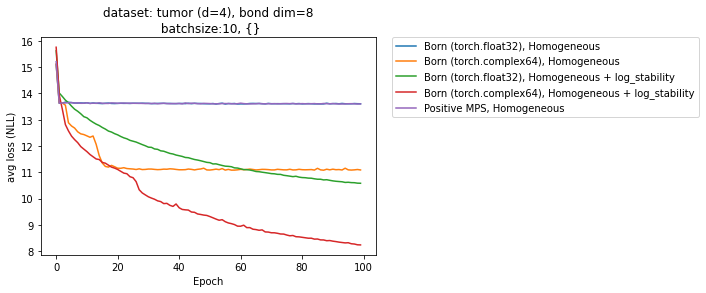

In [6]:
lossvals_hom = train_models(models_hom, batchsize=10, max_epochs=100)

In [7]:
lossvals = train_models(models, batchsize=10, max_epochs=100)

dataset: tumor
╭───────────────────────────
│Training Born (torch.float32), Non-homogeneous,
│         batchsize:10, torch.optim.adadelta, {}.


│(clipping right_boundary min -2.3e+04 to size 1000)


KeyboardInterrupt: 

In [ ]:
# modelhom_loss_values={}
# batchsize=35
# max_epochs=100
# optim_kwargs = dict(lr=0.05)
# for model in models:
#     loss_values = train(model, X, batchsize=batchsize, plot=False, max_epochs = max_epochs, **optim_kwargs)
#     plt.plot(loss_values, label=model.name)
#     plt.ylabel('avg loss (NLL)')
#     plt.xlabel('Epoch')
#     plt.title(f"dataset: {dataset} (d={d}), bond dim={D}\n batchsize:{batchsize}, {optim_kwargs}")
#     modelhom_loss_values["model.name"]=loss_values
# plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.show()

## Useful things?

In [ ]:
class TTrain(nn.Module):
    """Abstract class for Tensor Train models.  Use instantiating class.

    Parameters:
        D (int): bond dimension
        d (int): physical dimension (number of categories in data)
        dtype ([tensor.dtype]): 
            tensor.float for real, or tensor.cfloat for complex
    """
    def __init__(self, dataset, d, D, dtype, homogeneous=True, verbose=False):
        super().__init__()
        self.D = D
        self.d = d
        self.verbose = verbose
        self.homogeneous = homogeneous
        self.n_datapoints = dataset.shape[0]
        self.seqlen = dataset.shape[1]

        # choose weight initialization scheme
        w_init = torch.ones  # constant at 1
        # w_init = self.randomsign_ones  # 1 * +/-(/+j/-j)

        # the following are set to nn.Parameters thus are backpropped over
        k_core = (d*D*D)**-0.5 
        k_vectors = (d)**-0.5
        if homogeneous: # initialize single core to be repeated
            core = k_core * w_init((d, D, D), dtype=dtype)
            #core = torch.randn(d, D, D, dtype=dtype)
            self.core = nn.Parameter(core)
        else: # initialize seqlen different non-homogeneous cores
            core = k_core * w_init((self.seqlen, d, D, D), dtype=dtype)
            #core = torch.randn(self.seqlen, d, D, D, dtype=dtype)
            self.core = nn.Parameter(core)
        left_boundary = k_vectors * w_init(D, dtype=dtype)
        #left_boundary = torch.randn(D, dtype=dtype)
        self.left_boundary = nn.Parameter(left_boundary)
        right_boundary = k_vectors * w_init(D, dtype=dtype)
        #right_boundary = torch.randn(D, dtype=dtype)
        self.right_boundary = nn.Parameter(right_boundary)

    @staticmethod
    def randomsign_ones(shape, dtype=torch.float):
        """Makes a vector of ones with random sign, 
        or if dtype is torch.cfloat, randomized real or imaginary units"""
        x = torch.zeros(shape)
        if dtype==torch.cfloat:
            random4=torch.randint_like(x,4)
            r = x + 1*(random4==0) - 1*(random4==1) 
            i = x + 1*(random4==2) - 1*(random4==3)
            out = torch.complex(r,i)
        else:
            random2=torch.randint_like(x,2)
            out = x + 1*(random2==0) - 1*(random2==1) 
        return torch.tensor(out, dtype=dtype)